### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import scipy.stats
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal as mn


### Data Ingestion

In [2]:
metrics = pd.read_csv('metrics.csv')
hotels = pd.read_csv('hotels.csv')

In [ ]:
#def import_data():
    #metrics = pd.read_csv('./metrics.csv')
    #hotels = pd.read_csv('./hotels.csv')
    #print('metrics dataset:', metrics.head(), 'hotels dataset:', hotels.head(), sep='\n')
    #return metrics, hotels

In [3]:
metrics.head()

,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings
0,20230801,1,1,5,0
1,20230801,1,5,159,5
2,20230801,1,14,1,0
3,20230801,1,37,2,0
4,20230801,1,39,1,0


In [ ]:
#metrics.set_index('ymd', inplace = True)

### Data Exploration

In [4]:
metrics['advertiser_id'].value_counts().head()

5     1954
39    1574
37    1319
24    1194
1      627
Name: advertiser_id, dtype: int64

In [5]:
metrics.isnull().sum()

ymd              0
hotel_id         0
advertiser_id    0
n_clickouts      0
n_bookings       0
dtype: int64

In [6]:
hotels.head()

,hotel_id,stars,n_reviews,rating,city_id
0,1,3,3601.0,6.1,36
1,2,3,1949.0,8.6,36
2,3,2,899.0,6.8,71
3,4,3,3057.0,4.1,19
4,5,3,938.0,6.3,41


In [7]:
hotels.isnull().sum()

hotel_id     0
stars        0
n_reviews    1
rating       1
city_id      0
dtype: int64

In [8]:
hotels.dropna(inplace = True)

### Merge both the metrics and hotel dataset

Using just conversion rate on the metrics dataset will be inadequate for model building. Other variables from the hotel dataset should be brought in. 

In [9]:
df = pd.merge(metrics, hotels, on ='hotel_id', how = 'left')

In [10]:
#convert the day variable to data data type

df['ymd'] = df['ymd'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
#df['hotel_id'] = df['hotel_id'].astype('category')
#df['city_id'] = df['city_id'].astype('category')
#df['advertiser_id'] = df['advertiser_id'].astype('category')
#df[['hotel_id','city_id','advertiser_id']] = df[['hotel_id','city_id','advertiser_id']].apply(lambda x: x.astype('category'),axis=0)

In [11]:
## create a day variable from the "ymd" column to have more variables for prediction
df['day'] = df['ymd'].dt.day

In [ ]:
#set "ymd" variable as index

#df.set_index('ymd', inplace = True)

In [12]:
#create a conversion rate variable: n_bookings / n_clickouts

df['conv_rate'] = df['n_bookings']/ df['n_clickouts'] *100

In [13]:
df['conv_rate'] = df['conv_rate'].to_numpy()

In [14]:
df.describe()

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,day,conv_rate
count,10292.000000,10292.000000,10292.000000,10292.000000,10274.000000,10274.000000,10274.000000,10274.000000,10292.000000,10292.000000
mean,103.311601,21.663136,13.387583,0.334629,3.377068,4111.072026,7.862575,39.175978,5.497085,2.408461
std,64.945603,14.530521,41.079112,1.247971,1.221949,5044.490257,0.982829,21.138440,2.881235,9.789689
min,1.000000,1.000000,1.000000,0.000000,0.000000,10.000000,4.100000,1.000000,1.000000,0.000000
25%,42.000000,5.000000,1.000000,0.000000,3.000000,1072.000000,7.400000,28.000000,3.000000,0.000000
50%,97.000000,24.000000,3.000000,0.000000,4.000000,2146.000000,8.000000,34.000000,5.000000,0.000000
75%,160.000000,37.000000,11.000000,0.000000,4.000000,4469.000000,8.500000,51.000000,8.000000,0.000000
max,224.000000,43.000000,818.000000,25.000000,5.000000,23376.000000,9.400000,86.000000,10.000000,100.000000


In [15]:
## Remove the conversation rate of 100% which 1 click rate and 1 booking across the hotels

df = df.loc[~(df['conv_rate'] == 100)]

In [ ]:
#df.describe()

### Data Preprocessing: Checking for outliers and duplicates

In [ ]:
def z_score_outliers(array,
                     z_score_lower,
                     z_score_upper):

    z_scores = scipy.stats.zscore(array)
    outliers = (z_scores > 1.96) | (z_scores < -1.96)
    
    return array[outliers]

In [ ]:
#def z_score(df, threshold=1):
    #mean, std = np.mean(df), np.std(df)
    #z_score = np.abs((df - mean) / std)
    #keep = z_score < threshold
    #print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
    #print(f"Rejection {(~keep).sum()} points")
    #return keep

In [ ]:
#z_score(df['n_reviews'], threshold=3).sum()

In [16]:
#Check for Duplicate Values
if (len(df[df.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['rating'], y = train['conv_rate'])
plt.ylabel('Conversion', fontsize=13)
plt.xlabel('number of ratings', fontsize=13)
plt.show()

In [ ]:
from scipy.stats import norm
from scipy import stats
sns.distplot(train['conv_rate'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['conv_rate'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('conv_rate')
plt.title('Conversion rate distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['conv_rate'], plot=plt)
plt.show()

<Axes: >

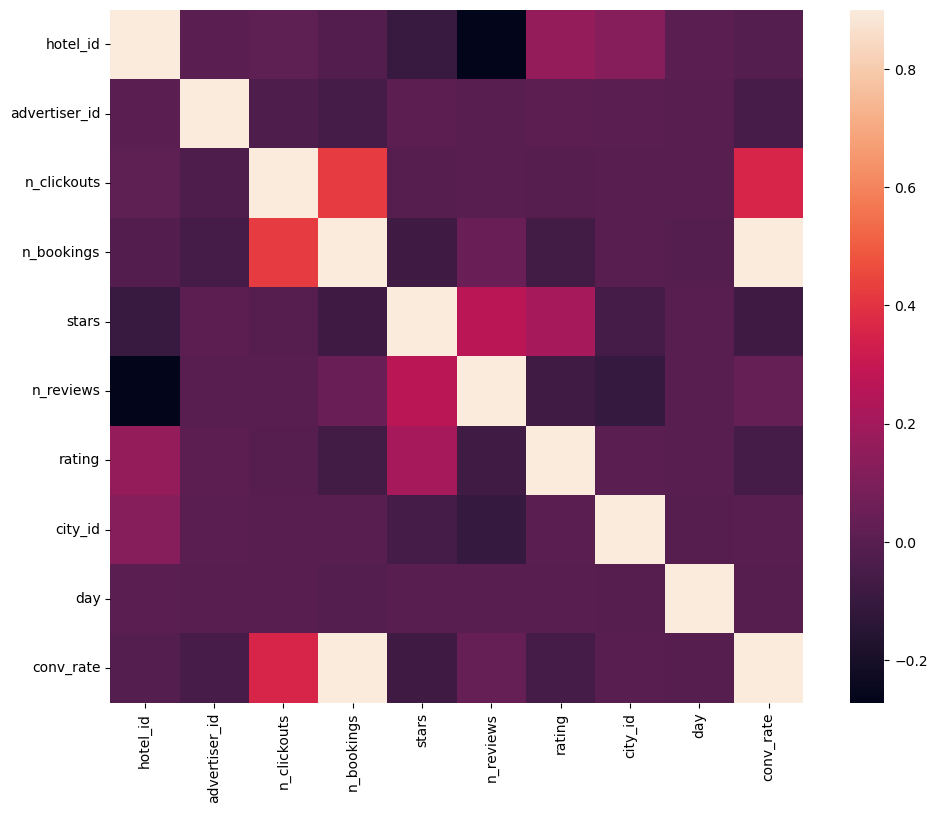

In [17]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df.corr(method ="kendall")
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

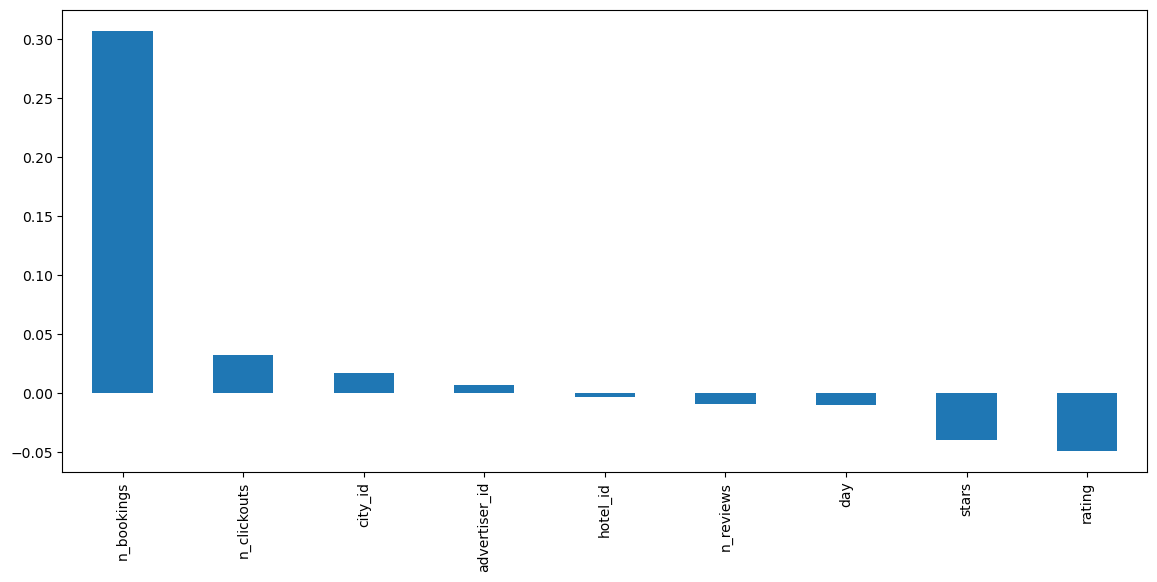

In [18]:
corr_with_conv_rate = df.corr()["conv_rate"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_conv_rate.drop("conv_rate").plot.bar()
plt.show();

In [19]:
df.groupby('ymd')['conv_rate'].mean()

ymd
2023-08-01    1.544824
2023-08-02    1.821077
2023-08-03    2.133092
2023-08-04    1.957418
2023-08-05    2.197665
2023-08-06    1.847325
2023-08-07    1.988551
2023-08-08    1.743678
2023-08-09    1.619239
2023-08-10    1.517074
Name: conv_rate, dtype: float64

In [20]:
df.isnull().sum()

ymd               0
hotel_id          0
advertiser_id     0
n_clickouts       0
n_bookings        0
stars            18
n_reviews        18
rating           18
city_id          18
day               0
conv_rate         0
dtype: int64

In [21]:
df.dropna(inplace = True)

<Axes: xlabel='ymd'>

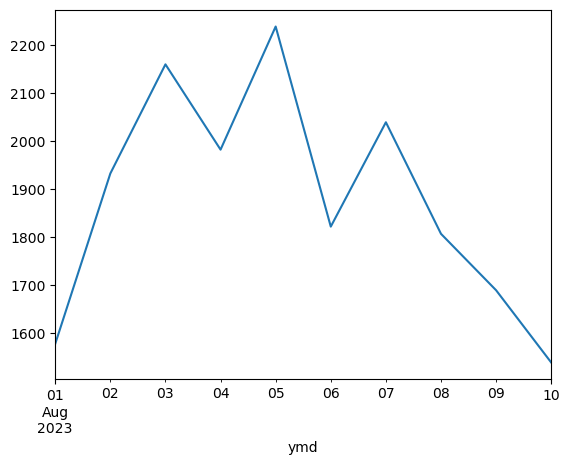

In [22]:
df.groupby(df['ymd']).apply(lambda x: x["conv_rate"].sum()).plot()

In [ ]:
#plt.plot('conv_rate')

In [ ]:
#df.fillna(0, inplace=True)

In [23]:
predictors = ['day','hotel_id','advertiser_id','stars','n_reviews','rating','city_id']

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#df[predictors] = scaler.fit_transform(df[predictors])

### Create a prediction function

In [24]:
# create a model - Regressor: the target is a continuous variable
rr = Ridge(alpha = 1, random_state = 123)

In [25]:
def fit_predict(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    dayz = sorted(data["ymd"].unique())
    
    for i in range(start, len(dayz), step):
        daytime = dayz[i]
        train = data[data["ymd"] < daytime]
        test = data[data["ymd"] == daytime]
        
        model.fit(train[predictors], train["conv_rate"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["conv_rate"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

### Model Training & Evaluation

In [26]:
predictions = fit_predict(df, rr, predictors,step = 1)

In [27]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [28]:
eval_results = evaluate_model(predictions['actual'], predictions['prediction'])

In [29]:
print(eval_results)

(3.3247654369922697, 6.423104421267733, 0.0009961595856842198)


In [30]:
print('Test r2 score: ', r2_score(predictions['actual'], predictions['prediction']))
test_mse1 = mean_squared_error(predictions['actual'], predictions['prediction'])
test_rmse1 = np.sqrt(test_mse1)
print('Test RMSE: %.4f' % test_rmse1)

Test r2 score:  0.0009961595856842198
Test RMSE: 6.4231


In [31]:
predictions

,actual,prediction
2098,0.000000,2.128476
2099,6.201550,2.168412
2100,0.000000,2.198364
2101,0.000000,2.487903
2102,0.000000,1.806411
...,...,...
10287,0.000000,1.255089
10288,0.000000,1.273100
10289,0.000000,1.315125
10290,0.000000,2.091988


### Part 1: Predict unseen data - ( August 11) 

In [32]:
#create a copy of the dataframe: df
data = df.copy()

In [33]:
data.head()

,ymd,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,day,conv_rate
0,2023-08-01,1,1,5,0,3.0,3601.0,6.1,36.0,1,0.000000
1,2023-08-01,1,5,159,5,3.0,3601.0,6.1,36.0,1,3.144654
2,2023-08-01,1,14,1,0,3.0,3601.0,6.1,36.0,1,0.000000
3,2023-08-01,1,37,2,0,3.0,3601.0,6.1,36.0,1,0.000000
4,2023-08-01,1,39,1,0,3.0,3601.0,6.1,36.0,1,0.000000


In [ ]:
#data = data[['day',"hotel_id", 'advertiser_id', 'n_clickouts','rating', 'city_id','n_reviews','stars', 'n_bookings', 'conv_rate']]

In [42]:
data.set_index('ymd', inplace = True)

### Data spliting and Preparation 

In [43]:
train = data.loc[:"20230810"]
test = data.loc["20230810":]

In [44]:
len(test)

1012

In [45]:
# Create a XGB regressor model
reg = XGBRegressor(n_estimators=20,max_depth=9)

# Fit the model on the training data
reg.fit(train[predictors], train['conv_rate'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
y_pred = reg.predict(test[predictors])

# Evaluate the model
mae = mean_absolute_error(test['conv_rate'], y_pred)
mse = mean_squared_error(test['conv_rate'], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test['conv_rate'], y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))


Mean Absolute Error (MAE): 1.6
Mean Squared Error (MSE): 13.09
Root Mean Squared Error (RMSE): 3.62
R-squared (R2) Score: 0.63


In [47]:
def eval_2(X_test, y_test, model):
    print('Evaluate the model on new data for August 11')
    y_pred_test = model.predict(X_test)
    print('predicted conversion rates :', y_pred_test)
    return y_pred_test

In [48]:
evaluated = eval_2(train[predictors], train['conv_rate'], reg)

Evaluate the model on new data for August 11
predicted conversion rates : [-0.06379621  2.4743447   0.07852095 ... -0.58606136 -0.10983487
  2.5611284 ]


In [49]:
len(y_pred)

1012

### Part 2: Predict - ( August 11) conversion rate

This method predict the target variable h steps ahead, while considering the position and length of the hotel_id with a specific day time.

The model is created by passing the value at the step t+h as the target variable ( conv_rate).

In [50]:
df2 = df.copy()

In [51]:
df2['ymd']= pd.to_datetime(df2['ymd'])

In [ ]:
#df2.set_index('ymd', inplace = True)

In [52]:
#train and test split by day of the month

train = df2[df2['ymd'] < '2023-08-09']
test = df2[df2['ymd'] >= '2023-08-10']

In [53]:
len(test)

1012

In [ ]:
# Prediction using Lags

In [54]:
lag = 1021  
p = np.zeros(len(test))
for h in range(len(test)):
    x = list()
    y = list()
    for t in range(lag, len(train)-h):
        x.append(train['conv_rate'].iloc[t-lag:t].values)
        y.append(train['conv_rate'].iloc[t+h])

    model = Ridge(alpha =1)
    model.fit(x, y)

    x_ = train['conv_rate'].iloc[-lag:].values
    p[h] = model.predict([x_])

In [55]:
print(p)

[ 4.61663186  3.79287781 -1.25365809 ... -0.79669661  7.94337382
  3.11531891]


In [ ]:
len(test)

### Predictions using AutoregForecaster

In [56]:
df = df.set_index('ymd')

In [57]:
#Split the data into train and test
train = df.loc["2023-08-01":]
test = df.loc["2023-08-10":]

In [58]:
test.shape

(1012, 10)

In [59]:
#regressor= LinearRegression()

In [60]:
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = len(test),
                 #transformer_y = StandardScaler()
             )
forecaster.fit(y=train['conv_rate'])

/home/dell54/anaconda3/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/dell54/anaconda3/lib/python3.10/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [61]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [   1    2    3 ... 1010 1011 1012] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1012 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 10213] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
fit_kwargs: {} 
Creation date: 2023-12-07 09:31:38 
Last fit date: 2023-12-07 09:31:38 
Skforecast version: 0.11.0 
Python version: 3.10.9 
Forecaster id: None 

## Make predictions using the ForecasterAutoreg

In [62]:
steps = 1012
predictions = forecaster.predict(steps=steps)
predictions.tail(5)

/home/dell54/anaconda3/lib/python3.10/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


2019    1.839228
2020    1.443063
2021    1.753975
2022    0.805931
2023    1.573551
Name: pred, dtype: float64

In [63]:
display(predictions.head(3))

1012   -0.232060
1013   -1.750124
1014    2.578810
Name: pred, dtype: float64

In [64]:
len(predictions)

1012

In [66]:
test.head()

,hotel_id,advertiser_id,n_clickouts,n_bookings,stars,n_reviews,rating,city_id,day,conv_rate
ymd,,,,,,,,,,
2023-08-10,1,1,1,0,3.0,3601.0,6.1,36.0,10,0.000000
2023-08-10,1,5,103,4,3.0,3601.0,6.1,36.0,10,3.883495
2023-08-10,1,37,1,0,3.0,3601.0,6.1,36.0,10,0.000000
2023-08-10,1,39,1,0,3.0,3601.0,6.1,36.0,10,0.000000
2023-08-10,2,5,34,0,3.0,1949.0,8.6,36.0,10,0.000000


In [67]:
test.index = test.index + pd.DateOffset(days=1)

In [68]:
colss = ['hotel_id','advertiser_id']

In [69]:
preds_data = test[colss]

In [70]:
preds_data['pred'] = np.array(predictions)

/tmp/ipykernel_43582/624704566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_data['pred'] = np.array(predictions)


In [71]:
preds_data['y_pred'] = np.array(y_pred) # predictions from Ridge model
preds_data['pred'] = np.array(predictions) # predictions from AutoregForecast
preds_data['p'] = np.array(p) # direct prediction

/tmp/ipykernel_43582/3142758834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_data['y_pred'] = np.array(y_pred) # predictions from Ridge model
/tmp/ipykernel_43582/3142758834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_data['pred'] = np.array(predictions) # predictions from AutoregForecast
/tmp/ipykernel_43582/3142758834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [72]:
preds_data.head()

,hotel_id,advertiser_id,pred,y_pred,p
ymd,,,,,
2023-08-11,1,1,-0.232060,0.236026,4.616632
2023-08-11,1,5,-1.750124,3.318741,3.792878
2023-08-11,1,37,2.578810,0.455084,-1.253658
2023-08-11,1,39,0.117882,0.266971,4.855415
2023-08-11,2,5,4.459314,1.636085,0.066281


In [74]:
pre_group = preds_data.groupby(['advertiser_id', 'hotel_id'])['pred'].mean()

In [75]:
pre_group

advertiser_id  hotel_id
1              1          -0.232060
               4           1.867089
               5          -0.987380
               7           2.827328
               8           0.231170
                             ...   
41             194         1.597958
               200         3.056939
               207         4.217528
               215         1.759309
43             141         0.560117
Name: pred, Length: 1012, dtype: float64

In [76]:
pre_group.to_csv('conversion_rate_predictions_SegunB.csv')